# Assignment 11/02/2025

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from skimage import color, restoration

## Loading images, conversion to grayscale

In [2]:
lenna_original_image = cv2.imread('./lenna_original.png')

In [3]:
grayscale_lenna_orig = cv2.cvtColor(lenna_original_image, cv2.COLOR_BGR2GRAY)

In [4]:
wire_bond_image = cv2.imread('./wire_bond.png')
point_detect_image = cv2.imread('./point_detection.png')
edge_detect_image = cv2.imread('./edge_detection.png')
hist_thresh_image = cv2.imread('./hist_thresh.png')
auto_thresh_image = cv2.imread('./automatic_thresh.png')

In [5]:
morphological_image = cv2.imread('./morph.png')
close_perim_image = cv2.imread('./close_perim.png')
grayscale_morph_image = cv2.cvtColor(morphological_image, cv2.COLOR_BGR2GRAY)
grayscale_close_perim_image = cv2.cvtColor(close_perim_image, cv2.COLOR_BGR2GRAY)

In [6]:
grayscale_wire_bond = cv2.cvtColor(wire_bond_image, cv2.COLOR_BGR2GRAY)
grayscale_point_detect = cv2.cvtColor(point_detect_image, cv2.COLOR_BGR2GRAY)
grayscale_edge_detect = cv2.cvtColor(edge_detect_image, cv2.COLOR_BGR2GRAY)
grayscale_hist_thresh = cv2.cvtColor(hist_thresh_image, cv2.COLOR_BGR2GRAY)
grayscale_auto_thresh = cv2.cvtColor(auto_thresh_image, cv2.COLOR_BGR2GRAY)

## Restoration

In [7]:
# applying simple averaging blur
mask = np.ones([3, 3])
mask /= 9

lenna_blurred = np.zeros_like(grayscale_lenna_orig)
img_height, img_width = grayscale_lenna_orig.shape

for i in range(1, img_height - 1):
    for j in range(1, img_width - 1):
        neighborhood = grayscale_lenna_orig[i-1:i+2, j-1:j+2]
        lenna_blurred[i, j] = int(np.sum(neighborhood * mask))

In [8]:
# adding noise to the image with mean 0 std 25
noise = np.random.normal(0, 25, grayscale_lenna_orig.shape)
lenna_noise = np.clip(lenna_blurred + noise, 0, 255)

Text(0.5, 1.0, 'Averaging blur + Noise')

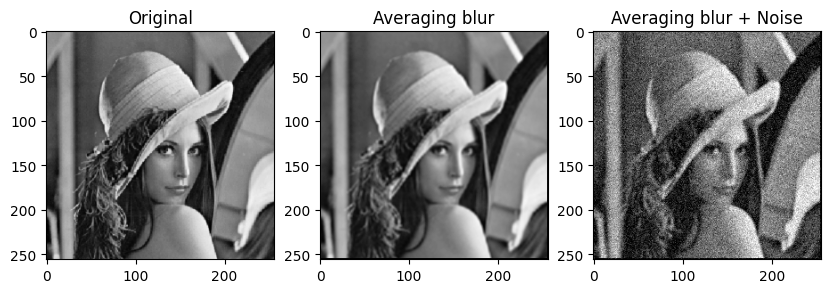

In [9]:
plt.figure(figsize=(10, 15))

plt.subplot(1, 3, 1)
plt.imshow(grayscale_lenna_orig, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(lenna_blurred, cmap='gray')
plt.title("Averaging blur")

plt.subplot(1, 3, 3)
plt.imshow(lenna_noise, cmap='gray')
plt.title("Averaging blur + Noise")

### Inverse Filtering

In [10]:
padded_mask = np.zeros_like(lenna_blurred)
padded_mask[:mask.shape[0], :mask.shape[1]] = mask
H = fft.fft2(padded_mask)
H[H == 0] = 1e-6  # avoid div by 0 error

In [11]:
F = fft.fft2(lenna_blurred)
F_restored = F / H
grayscale_lenna_restored_inverse = np.real(fft.ifft2(F_restored))

Text(0.5, 1.0, 'After')

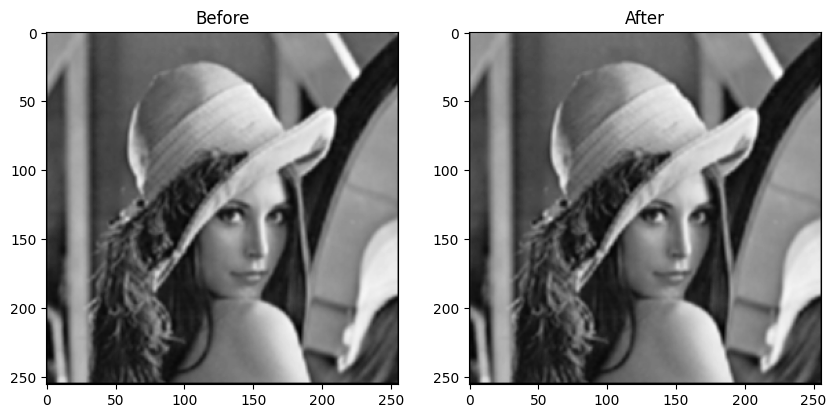

In [12]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(lenna_blurred, cmap='gray')
plt.title("Before")

plt.subplot(1, 2, 2)
plt.imshow(grayscale_lenna_restored_inverse, cmap='gray')
plt.title("After")

### Wiener Deconvolution

In [13]:
grayscale_lenna_restored_wiener = restoration.wiener(lenna_noise, mask, 1, clip=False)

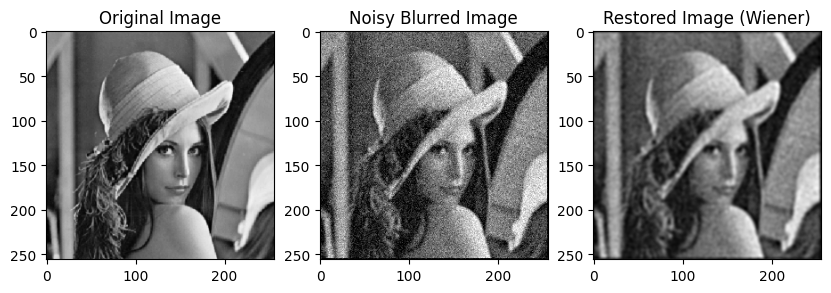

In [14]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(grayscale_lenna_orig, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Noisy Blurred Image")
plt.imshow(lenna_noise, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Restored Image (Wiener)")
plt.imshow(grayscale_lenna_restored_wiener, cmap='gray')

### Constrained Least Square

In [15]:
noisy_blurred_image = lenna_noise

In [16]:
G = fft.fft2(noisy_blurred_image)
H = fft.fft2(mask, s=lenna_noise.shape)
lambda_val = 0.01

In [17]:
# laplacian
P = np.zeros_like(H)
P[0, 1] = P[1, 0] = P[-1, 0] = P[0, -1] = -1
P[0, 0] = 4
P = fft.fft2(P, s=lenna_noise.shape)

In [18]:
H_conj = np.conj(H)
CLS_filter = H_conj / (np.abs(H)**2 + lambda_val * np.abs(P)**2)

In [19]:
F_restored = CLS_filter * G
restored_image = np.real(fft.ifft2(F_restored))

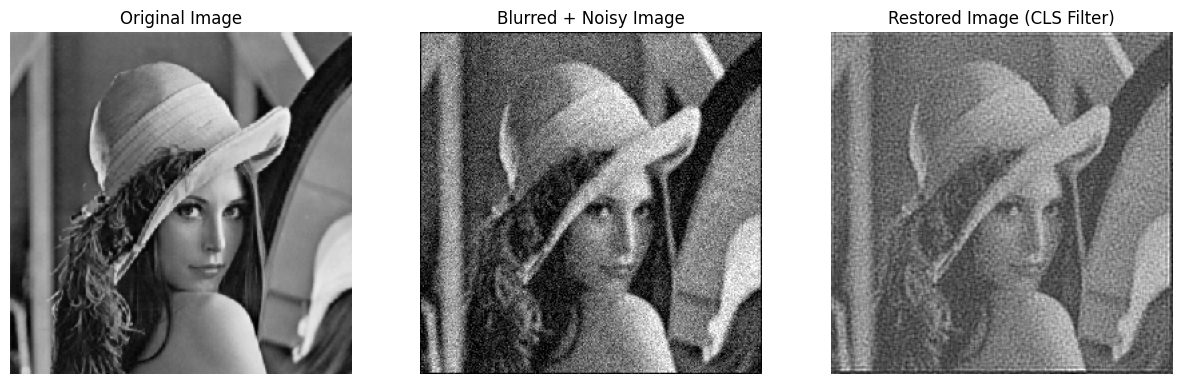

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(lenna_original_image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(lenna_noise, cmap='gray')
ax[1].set_title("Blurred + Noisy Image")
ax[1].axis("off")

ax[2].imshow(restored_image, cmap='gray')
ax[2].set_title("Restored Image (CLS Filter)")
ax[2].axis("off")

plt.show()

## Segmentation

### Point Detection

In [21]:
mask = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

In [22]:
point_detect_result = np.zeros_like(grayscale_point_detect)
img_height, img_width = grayscale_point_detect.shape
threshold = 30

In [23]:
for i in range(1, img_height - 1):
    for j in range(1, img_width - 1):
        neighborhood = grayscale_point_detect[i-1:i+2, j-1:j+2]
        point_detect_result[i, j] = 0 if int(np.sum(neighborhood * mask)) < threshold else 1

Text(0.5, 1.0, 'Point Detection with Thresholding')

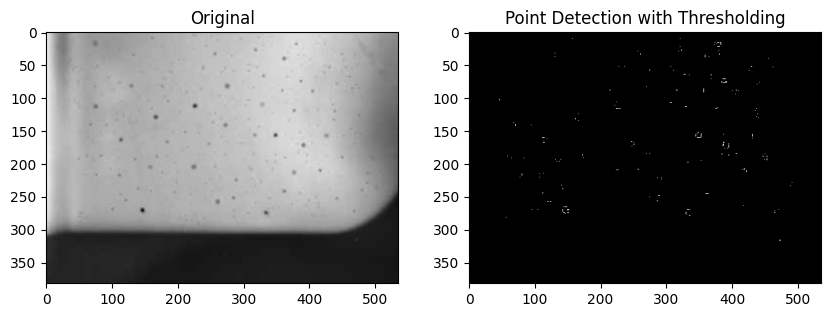

In [24]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_point_detect, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(point_detect_result, cmap='gray')
plt.title("Point Detection with Thresholding")

### Line Detection

In [25]:
mask = np.array([[-1, -1, 2], [-1, 2, -1], [2, -1, -1]])

In [26]:
line_detect_result = np.zeros_like(grayscale_wire_bond)
img_height, img_width = grayscale_wire_bond.shape
threshold = 30

In [27]:
for i in range(1, img_height - 1):
    for j in range(1, img_width - 1):
        neighborhood = grayscale_wire_bond[i-1:i+2, j-1:j+2]
        line_detect_result[i, j] = 0 if int(np.sum(neighborhood * mask)) < threshold else 1

Text(0.5, 1.0, 'Line Detection with Thresholding')

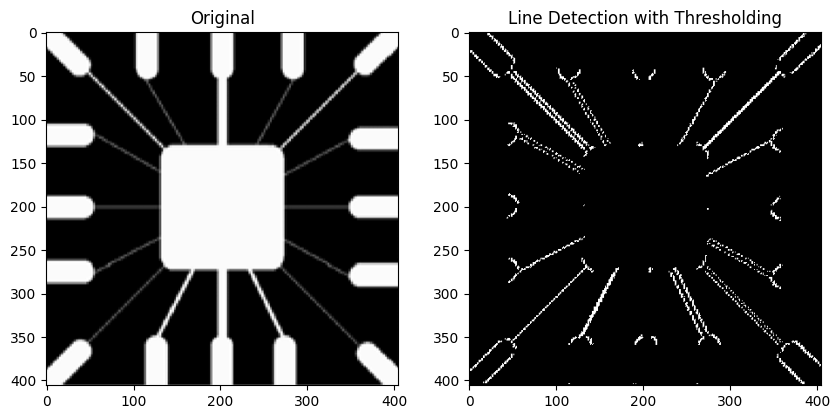

In [28]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_wire_bond, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(line_detect_result, cmap='gray')
plt.title("Line Detection with Thresholding")

### Edge Detection

In [29]:
sobel_mask = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
prewitt_mask = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
canny_mask = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
log_mask = np.array([
    [0,  0, -1,  0,  0],
    [0, -1, -2, -1,  0],
    [-1, -2, 16, -2, -1],
    [0, -1, -2, -1,  0],
    [0,  0, -1,  0,  0]
])

In [30]:
sobel_result = np.zeros_like(grayscale_edge_detect)
prewitt_result = np.zeros_like(grayscale_edge_detect)
canny_result = np.zeros_like(grayscale_edge_detect)
log_result = np.zeros_like(grayscale_edge_detect)

In [31]:
img_height, img_width = grayscale_edge_detect.shape
threshold = 30

#### Sobel

In [32]:
for i in range(1, img_height - 1):
    for j in range(1, img_width - 1):
        neighborhood = grayscale_edge_detect[i-1:i+2, j-1:j+2]
        sobel_result[i, j] = 0 if int(np.sum(neighborhood * sobel_mask)) < threshold else 1

#### Prewitt

In [33]:
for i in range(1, img_height - 1):
    for j in range(1, img_width - 1):
        neighborhood = grayscale_edge_detect[i-1:i+2, j-1:j+2]
        prewitt_result[i, j] = 0 if int(np.sum(neighborhood * prewitt_mask)) < threshold else 1

#### Canny

In [34]:
for i in range(1, img_height - 1):
    for j in range(1, img_width - 1):
        neighborhood = grayscale_edge_detect[i-1:i+2, j-1:j+2]
        canny_result[i, j] = 0 if int(np.sum(neighborhood * canny_mask)) < threshold else 1

#### Laplacian of Gaussian

In [35]:
for i in range(2, img_height - 2):
    for j in range(2, img_width - 2):
        neighborhood = grayscale_edge_detect[i-2:i+3, j-2:j+3]
        log_result[i, j] = 0 if int(np.sum(neighborhood * log_mask)) < threshold else 1

#### Results

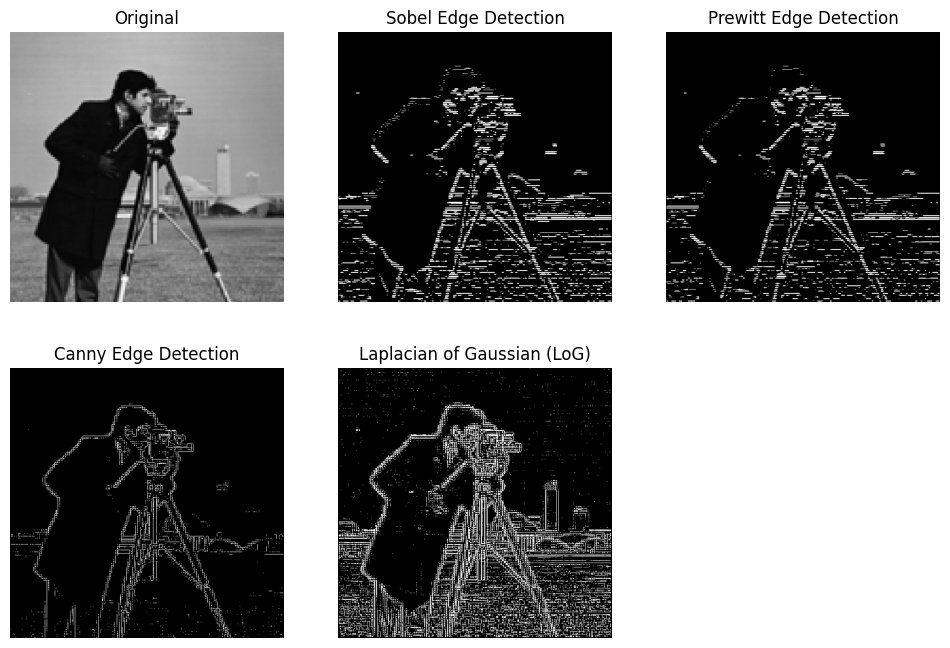

In [36]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(grayscale_edge_detect, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(sobel_result, cmap='gray')
plt.title("Sobel Edge Detection")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(prewitt_result, cmap='gray')
plt.title("Prewitt Edge Detection")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(canny_result, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(log_result, cmap='gray')
plt.title("Laplacian of Gaussian (LoG)")
plt.axis('off')

plt.show()

### Thresholding

#### Histogram based

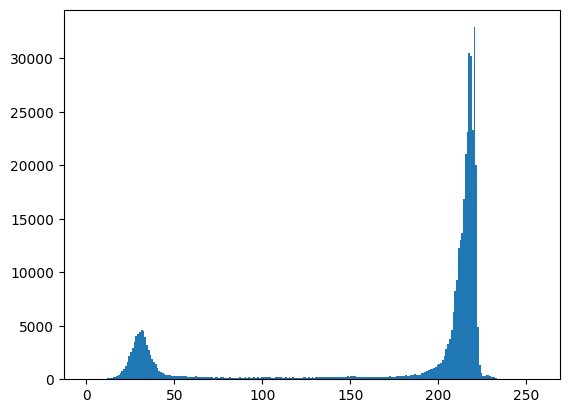

In [37]:
# FROM DOCUMENTATION: https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html
_ = plt.hist(grayscale_hist_thresh.ravel(), 256, [0,256])

In [38]:
def threshold(x, thresh = 125):
    if x <= thresh:
        return 0
    else:
        return 255
bw_fun = np.vectorize(threshold)

In [39]:
hist_thresh_result = bw_fun(grayscale_hist_thresh)

Text(0.5, 1.0, 'Histogram Based Thresholding')

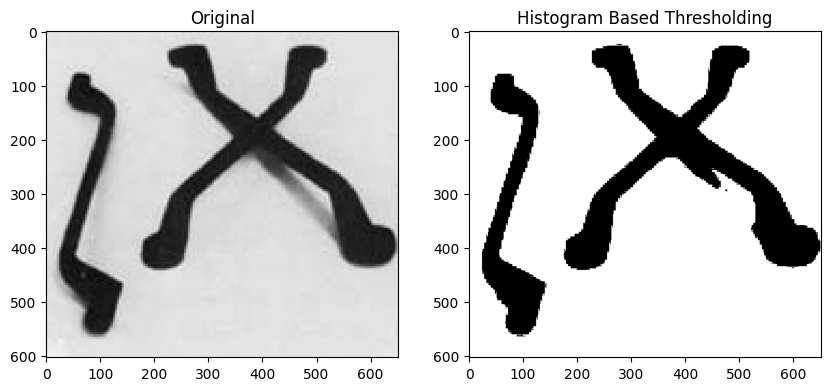

In [40]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_hist_thresh, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(hist_thresh_result, cmap='gray')
plt.title("Histogram Based Thresholding")

#### Automatic

In [41]:
T = 175
break_thresh = 1
del_T = break_thresh + 1 # to enter the loop

In [42]:
while(del_T > break_thresh):
    G1 = grayscale_auto_thresh[grayscale_auto_thresh <= T]
    G2 = grayscale_auto_thresh[grayscale_auto_thresh > T]
    
    mu1 = G1.mean()
    mu2 = G2.mean()
    
    new_T = (mu1 + mu2) / 2
    del_T = abs(new_T - T)
    T = new_T

In [43]:
def threshold(x, thresh=T):
    return 0 if x <= thresh else 255

bw_fun_auto = np.vectorize(threshold)
auto_thresh_result = bw_fun_auto(grayscale_auto_thresh)

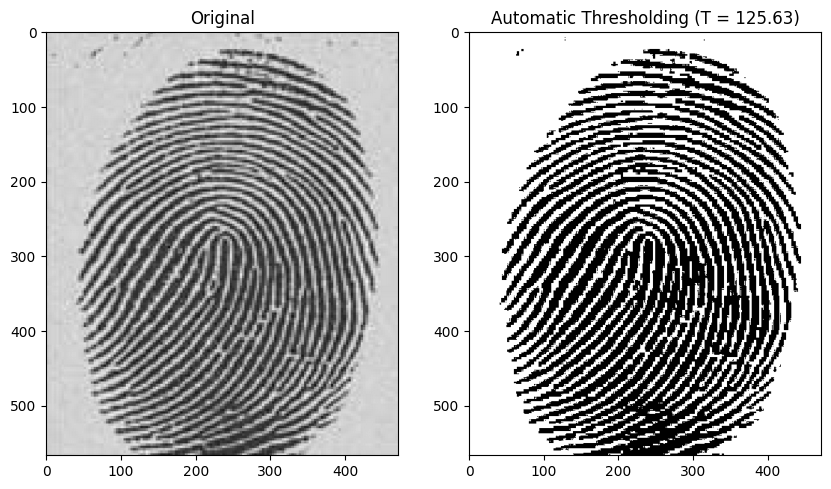

In [44]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_auto_thresh, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(auto_thresh_result, cmap='gray')
plt.title(f"Automatic Thresholding (T = {T:.2f})")

plt.show()

#### Optimal (Otsu)

In [45]:
# FROM DOCUMENTATION: https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
blur = cv2.GaussianBlur(grayscale_auto_thresh,(5,5),0)
# find normalized_histogram, and its cumulative distribution function
hist = cv2.calcHist([blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.sum()
Q = hist_norm.cumsum()
bins = np.arange(256)
fn_min = np.inf
thresh = -1
for i in range(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    if q1 < 1.e-6 or q2 < 1.e-6:
        continue
    b1,b2 = np.hsplit(bins,[i]) # weights
    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i
# find otsu's threshold value with OpenCV function
ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print( "{} {}".format(thresh,ret) )

129 128.0


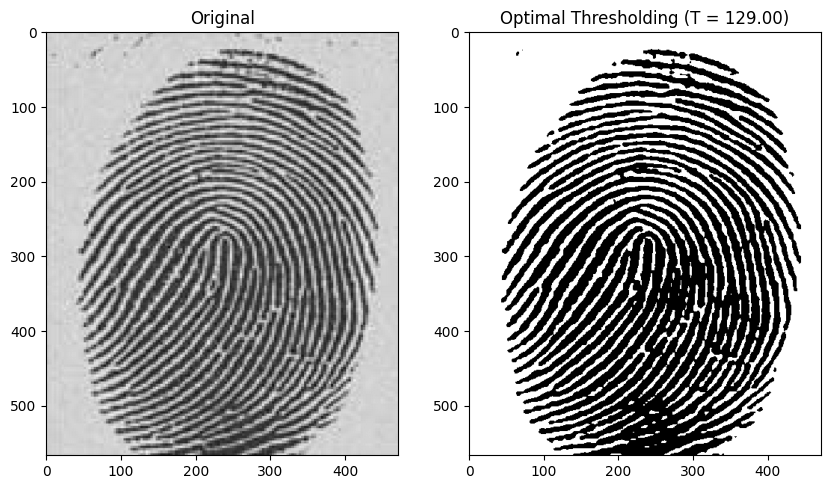

In [46]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_auto_thresh, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(otsu, cmap='gray')
plt.title(f"Optimal Thresholding (T = {thresh:.2f})")

plt.show()

## Morphological Operations

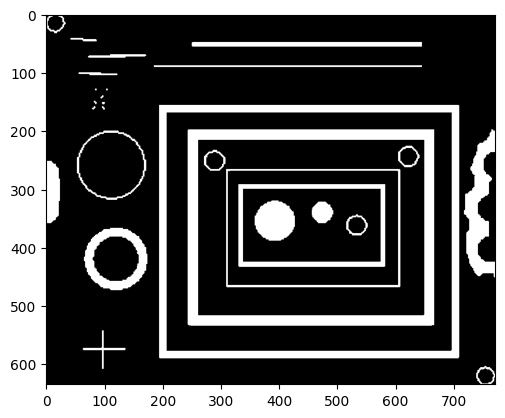

In [47]:
def threshold(x, thresh = 55):
    if x <= thresh:
        return 0
    else:
        return 255
bw_fun = np.vectorize(threshold)
bw_image = bw_fun(grayscale_morph_image)
plt.imshow(bw_image, cmap="gray")

### Dilation

In [48]:
rows, cols = bw_image.shape
dilation_result = np.zeros_like(bw_image)
for i in range(rows):
    for j in range(1, cols - 1):
        if(255 in bw_image[i, j-1:j+2]):
            dilation_result[i, j] = 255

Text(0.5, 1.0, 'With Dilation')

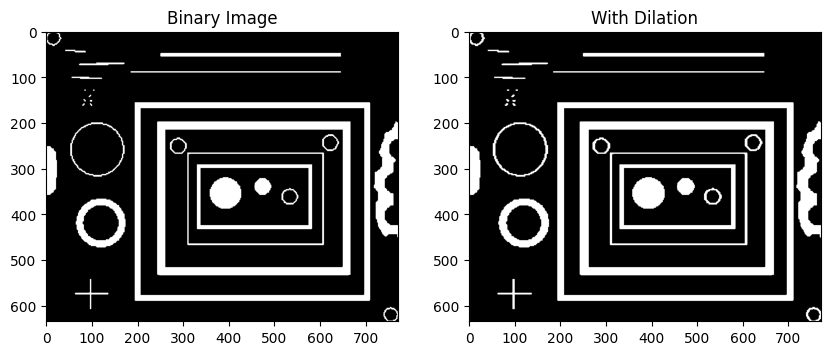

In [49]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(bw_image, cmap='gray', vmin=0, vmax=255)
plt.title("Binary Image")

plt.subplot(1, 2, 2)
plt.imshow(dilation_result, cmap='gray', vmin=0, vmax=255)
plt.title("With Dilation")

### Erosion

In [50]:
erosion_result = bw_image.copy()
for i in range(rows):
    for j in range(2, cols - 2):
        if(0 in bw_image[i, j-2:j+3]):
            erosion_result[i, j] = 0

Text(0.5, 1.0, 'With Erosion')

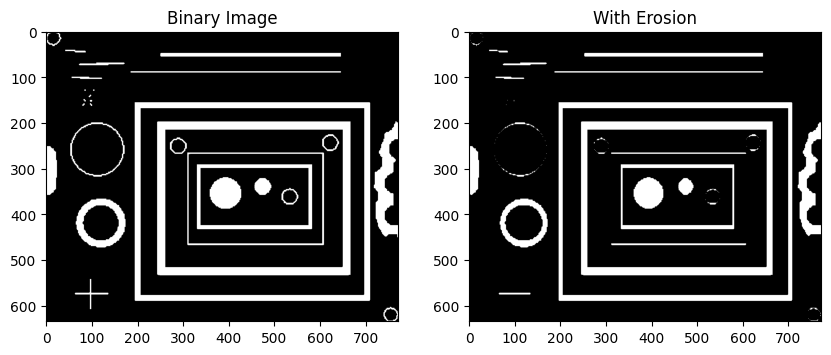

In [51]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(bw_image, cmap='gray', vmin=0, vmax=255)
plt.title("Binary Image")

plt.subplot(1, 2, 2)
plt.imshow(erosion_result, cmap='gray', vmin=0, vmax=255)
plt.title("With Erosion")

### Open

In [52]:
open_result = np.zeros_like(bw_image)
for i in range(rows):
    for j in range(3, cols - 3):
        if(255 in erosion_result[i, j-3:j+4]):
            open_result[i, j] = 255

Text(0.5, 1.0, 'With Open')

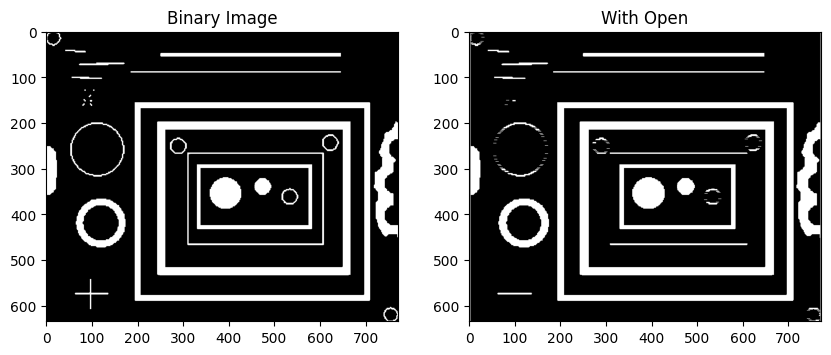

In [53]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(bw_image, cmap='gray', vmin=0, vmax=255)
plt.title("Binary Image")

plt.subplot(1, 2, 2)
plt.imshow(open_result, cmap='gray', vmin=0, vmax=255)
plt.title("With Open")

### Close

In [54]:
bw_close_perim = bw_fun(grayscale_close_perim_image)
rows, cols = bw_close_perim.shape
dilation_result = np.zeros_like(bw_close_perim)
for i in range(rows):
    for j in range(3, cols - 3):
        if(255 in bw_close_perim[i, j-3:j+4]):
            dilation_result[i, j] = 255

In [55]:
close_result = dilation_result.copy()
for i in range(rows):
    for j in range(2, cols - 2):
        if(0 in dilation_result[i, j-2:j+3]):
            close_result[i, j] = 0

Text(0.5, 1.0, 'With Close')

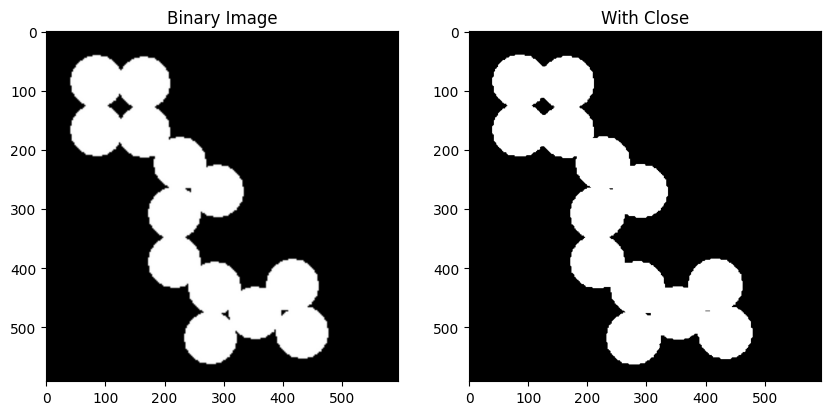

In [56]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(close_perim_image, cmap='gray', vmin=0, vmax=255)
plt.title("Binary Image")

plt.subplot(1, 2, 2)
plt.imshow(close_result, cmap='gray', vmin=0, vmax=255)
plt.title("With Close")

### Perimeter

In [57]:
perim_result = np.zeros_like(bw_close_perim)
for i in range(1, rows-1):
    for j in range(1, cols-1):
        if bw_close_perim[i, j] != 0 and (bw_close_perim[i - 1, j] == 0 or bw_close_perim[i + 1, j] == 0 or bw_close_perim[i, j - 1] == 0 or bw_close_perim[i, j + 1] == 0):
            perim_result[i, j] = 255

Text(0.5, 1.0, 'Perimeter')

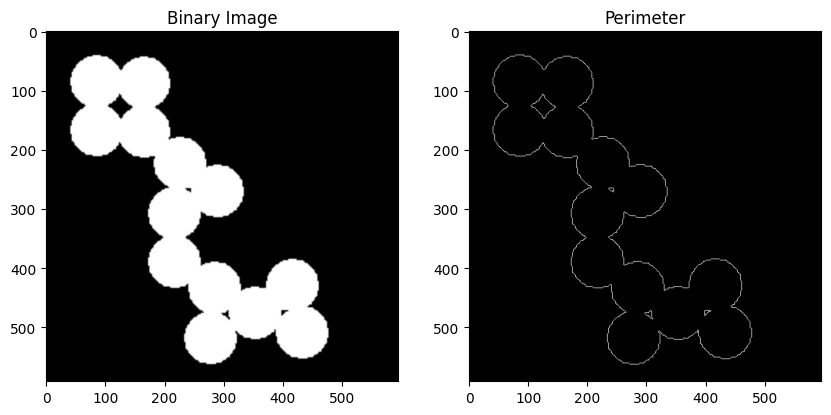

In [58]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(close_perim_image, cmap='gray', vmin=0, vmax=255)
plt.title("Binary Image")

plt.subplot(1, 2, 2)
plt.imshow(perim_result, cmap='gray', vmin=0, vmax=255)
plt.title("Perimeter")